In [1]:
import os
import numpy as np

import fiona
import rasterio
import rasterio.mask
from rasterio.windows import Window

import geopandas as gpd
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import colors

# Project and Control polygons

In [2]:
path = "../data/car/acre/"
folders = [name for name in os.listdir(path) if "SHAPE" in name]
df = gpd.GeoDataFrame()
for folder in folders:
    df_new = gpd.read_file(path + folder + "/AREA_IMOVEL/AREA_IMOVEL.shp")
    df = pd.concat([df, df_new])

<Axes: >

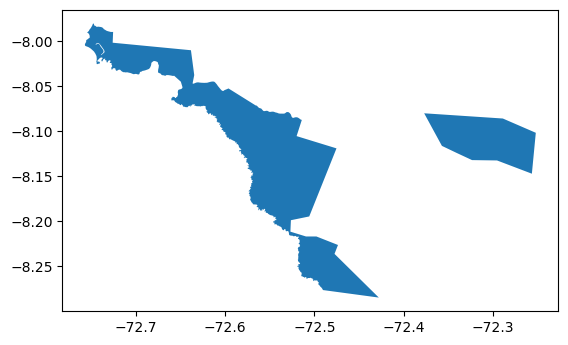

In [3]:
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
path_pa = "../data/pa/ValparaisoProperty (Kml).kml"
pa = gpd.read_file(path_pa, driver='KML')
pa = pa.to_crs("EPSG:4674")
pa.plot()

In [4]:
df.head()

,COD_IMOVEL,NUM_AREA,COD_ESTADO,NOM_MUNICI,NUM_MODULO,TIPO_IMOVE,SITUACAO,CONDICAO_I,geometry
0,AC-1200203-960F42AA267B42AA99796B9BA2014065,104.831639,AC,Cruzeiro do Sul,1.0483,IRU,AT,Aguardando anÃ¡lise,"POLYGON ((-72.44126 -7.79968, -72.41918 -7.795..."
1,AC-1200203-AD3A9DC93BEA4F9E9191410507E768F3,98.999439,AC,Cruzeiro do Sul,0.9900,IRU,AT,Aguardando anÃ¡lise,"POLYGON ((-72.43808 -7.81534, -72.43284 -7.814..."
2,AC-1200203-E3E678F3F10E4F43930A798A3CB21024,33.116394,AC,Cruzeiro do Sul,0.3312,IRU,AT,Aguardando anÃ¡lise,"POLYGON ((-72.39974 -7.75967, -72.39692 -7.759..."
3,AC-1200203-FDBE7665A84543D39A3A1426DFB99D93,93.019743,AC,Cruzeiro do Sul,0.9302,IRU,AT,Aguardando anÃ¡lise,"POLYGON ((-72.33497 -7.77499, -72.33939 -7.774..."
4,AC-1200203-ABA3D38DC7934EDB8FCF6B00C50FA0AB,2.960736,AC,Cruzeiro do Sul,0.0296,IRU,AT,Aguardando anÃ¡lise,"POLYGON ((-72.81086 -7.57448, -72.80826 -7.572..."


In [5]:
def load_biomass_data(year, shape, resolution=250):
    path_bio = f"../data/biomass/{resolution}m/" + f"mapbiomas-brazil-collection-70-acre-{year}.tif"
    with rasterio.open(path_bio) as src:
        if shape is not None:
            bio_data, out_transform = rasterio.mask.mask(src, shape, crop=True)
        else:
            bio_data = src.read(1)
        bio_data = np.squeeze(bio_data)
        out_meta = src.meta
    return bio_data

def transform_to_labels(bio_data):
    '''
    class_dict = {1:0, 3:0, 4:0, 5:0,49:0, # forest
                10:1,11:1,12:1,32:1,29:1,13:1, 13:1, 50:1, # natural
                14:2,15:2,18:2,19:2,39:2,20:2,40:2,61:2,41:2,36:2,46:2,47:2,48:2,9:2,21:2, # farming
                22:3,23:3,24:3,30:3,25:3, # urban
                26:4,33:4,31:4, # water
                27:5,0:5} # unobserved
    '''
    class_dict = {1:0, 3:0, 4:0, 5:0,49:0, # forest
                10:1,11:1,12:1,32:1,29:1,13:1, 13:1, 50:1, # natural
                14:1,15:1,18:1,19:1,39:1,20:1,40:1,61:1,41:1,36:1,46:1,47:1,48:1,9:1,21:1, # farming
                22:1,23:1,24:1,30:1,25:1, # urban
                26:1,33:1,31:1, # water
                27:2,0:2} # unobserved
    bio_data_new = np.zeros_like(bio_data)
    for key, value in class_dict.items():
        bio_data_new[bio_data == key] = value
    return np.array(bio_data_new, dtype=np.int8)

In [6]:
df['area_6933'] = df.geometry.to_crs("EPSG:6933").area
print('Total shape files: ', df.shape[0])

pa_area = pa.to_crs("EPSG:6933").area.sum()
df = df[(df.area_6933 > 0.75 * pa_area) & (df.area_6933 < 1.25 * pa_area)]
print('Area filtered shape files: ', df.shape[0])

for polygon in pa.geometry:
    df = df[np.invert(df.overlaps(polygon).values)]
print('Overlapping filtered shape files: ', df.shape[0])

forest_cover_1985 = []
for car in df.iterrows():
    bio_data = load_biomass_data(1985, [car[1].geometry], resolution=250)
    bio_data = transform_to_labels(bio_data)
    unobserved = np.max(bio_data)
    forest_cover = np.count_nonzero(bio_data == 0) / np.count_nonzero(bio_data < unobserved)
    forest_cover_1985.append(forest_cover)
df['fc_1985'] = forest_cover_1985
df = df[df.fc_1985 >= 0.9]
print('Sufficiently covered with forest: ', df.shape[0])

Total shape files:  41902
Area filtered shape files:  39
Overlapping filtered shape files:  38
Sufficiently covered with forest:  37


/opt/homebrew/Caskroom/miniforge/base/envs/semester_project/lib/python3.11/site-packages/shapely/predicates.py:853: RuntimeWarning: invalid value encountered in overlaps
  return lib.overlaps(a, b, **kwargs)


In [7]:
df.head()

,COD_IMOVEL,NUM_AREA,COD_ESTADO,NOM_MUNICI,NUM_MODULO,TIPO_IMOVE,SITUACAO,CONDICAO_I,geometry,area_6933,fc_1985
1627,AC-1200203-04A48AC64E814F2BA96CB485926BC011,29615.705033,AC,Cruzeiro do Sul,296.1571,IRU,AT,Aguardando analise,"POLYGON ((-73.23117 -8.20210, -73.26568 -8.199...",2.961071e+08,0.999792
1103,AC-1200401-9AE6AF5AF1EC44348F329EDD524FFB68,32575.548444,AC,Rio Branco,465.0163,IRU,PE,"Analisado com pendÃªncias, aguardando retifica...","POLYGON ((-68.55488 -9.92606, -68.53887 -9.931...",3.259910e+08,0.997559
4849,AC-1200401-230F0980331442FCA98C9AF4F5857FD0,29812.021476,AC,Rio Branco,425.8860,IRU,PE,Aguardando analise,"POLYGON ((-68.56632 -10.02909, -68.56505 -10.0...",2.983487e+08,0.997748
5327,AC-1200401-EAF118B9776847339332FAE206C8A9FC,25045.492465,AC,Rio Branco,357.7927,IRU,AT,"Analisado, aguardando regularizaÃ§Ã£o ambienta...","POLYGON ((-68.19602 -10.03285, -68.19557 -10.0...",2.506045e+08,0.999756
5366,AC-1200401-333D23771D354B1891D047C194E1810A,22091.162692,AC,Rio Branco,315.5590,IRU,PE,"Analisado com pendÃªncias, aguardando retifica...","POLYGON ((-68.46465 -9.54818, -68.46435 -9.549...",2.210663e+08,0.950706


<Axes: >

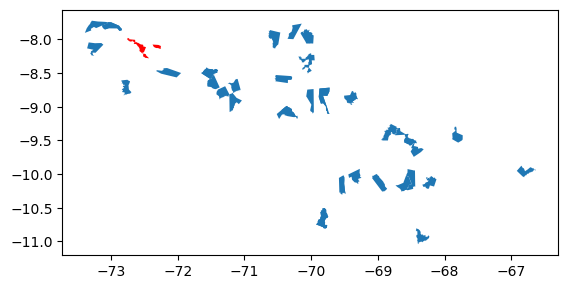

In [8]:
fig, ax = plt.subplots()
df.plot(ax=ax)
pa.plot(ax=ax, color='red')

# Biomass data

In [9]:
bio_data = load_biomass_data(2021, df.geometry)
bio_data = transform_to_labels(bio_data)

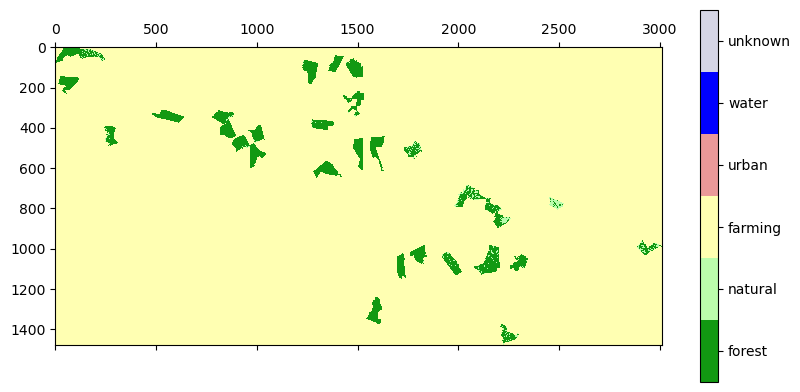

In [10]:
cmap = colors.ListedColormap(['#129912','#bbfcac','#ffffb2','#ea9999','#0000ff', '#D5D5E5'])
mat = plt.matshow(bio_data,cmap=cmap,vmin = -.5, vmax = 5.5)
cax = plt.colorbar(mat, ticks=np.arange(0,6))
cax.ax.set_yticklabels(['forest', 'natural', 'farming', 'urban', 'water', 'unknown'])
plt.show()

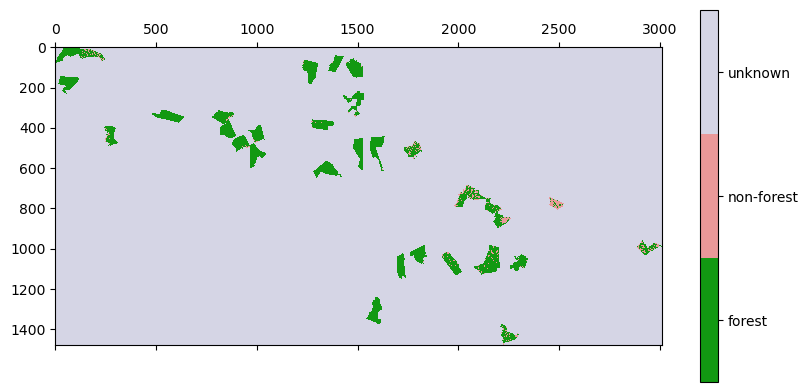

In [11]:
cmap = colors.ListedColormap(['#129912','#ea9999', '#D5D5E5'])
mat = plt.matshow(bio_data,cmap=cmap,vmin = -.5, vmax = 2.5)
cax = plt.colorbar(mat, ticks=np.arange(0,3))
cax.ax.set_yticklabels(['forest', 'non-forest', 'unknown'])
plt.show()

# Deforestation

In [12]:
from tqdm import tqdm
years = [2015, 2016, 2017, 2018]
bio_data_dict = {}
for year in tqdm(years):
    bio_data = load_biomass_data(year, None, resolution=30)
    bio_data = transform_to_labels(bio_data)
    bio_data_dict[year] = bio_data

100%|██████████| 4/4 [00:11<00:00,  2.76s/it]


In [13]:
deforestation = np.zeros_like(bio_data_dict[years[0]], dtype=bool)
for year in years[1:]:
    deforested = bio_data_dict[years[0]] - bio_data_dict[year]
    deforestation = deforestation | (deforested < 0)

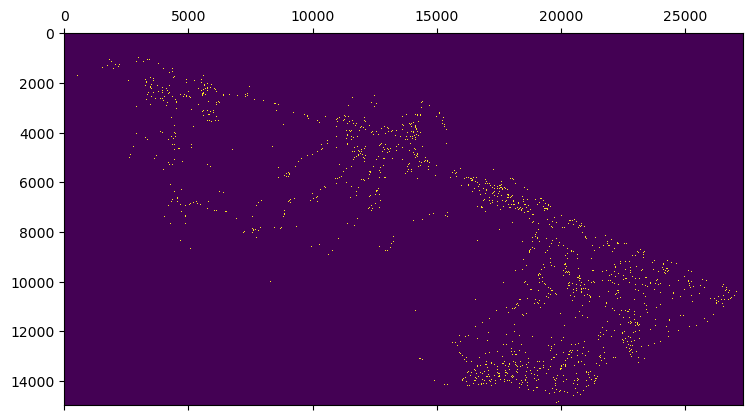

Initial Forest | Non-Forest | Unknown:  163729596 22114289 223363668
Final Forest | Non-Forest | Unknown:  162468306 23375497 223363750
2338405


In [14]:
plt.matshow(deforestation)
plt.show()
print('Initial Forest | Non-Forest | Unknown: ', np.count_nonzero(bio_data_dict[years[0]] == 0), np.count_nonzero(bio_data_dict[years[0]] == 1), np.count_nonzero(bio_data_dict[years[0]] == 2))
print('Final Forest | Non-Forest | Unknown: ', np.count_nonzero(bio_data_dict[years[-1]] == 0), np.count_nonzero(bio_data_dict[years[-1]] == 1), np.count_nonzero(bio_data_dict[years[-1]] == 2))
print(np.count_nonzero(deforestation == True))

In [22]:
deforestation_rates = []
d = 400
for i in range(int(deforestation.shape[0]/d)):
    for j in range(int(deforestation.shape[1])):
        window = deforestation[i*d:(i+1)*d, j*d:(j+1)*d]
        deforestation_rates.append(np.sum(window)/(d**2))

In [23]:
deforestation_rates = np.array(deforestation_rates)
deforestation_rates[deforestation_rates > 0].shape

(1088,)

# FABDEM Elevation

In [179]:
path_fabdem = "../data/fabdem/" + "S10W070-N00W060_FABDEM_V1-2/" + "S01W061_FABDEM_V1-2.tif"
fabdem_data = rasterio.open(path_fabdem)
print(fabdem_data.bounds)
print(fabdem_data.shape)
print(fabdem_data.count)
fabdem_acre = fabdem_data.read(1)


BoundingBox(left=-61.00013888888889, bottom=-0.9998611111111111, right=-60.00013888888889, top=0.0001388888888888889)
(3600, 3600)
1


In [180]:
path_fabdem = "../data/fabdem/" + "S10W070-N00W060_FABDEM_V1-2/"
squares = [name for name in os.listdir(path_fabdem)]
for square in squares:
    fabdem_data = rasterio.open(path_fabdem + square)
    fabdem_data.close()

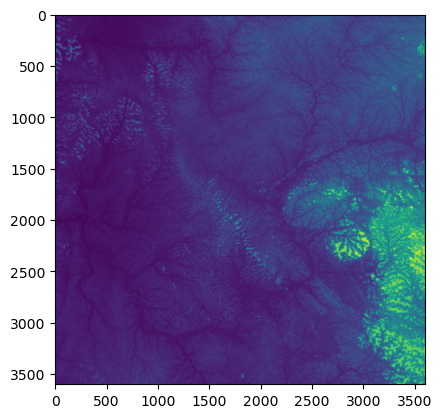

In [181]:
plt.imshow(fabdem_acre)
plt.show()

# LANDSAT

In [182]:
path_landsat = "../data/landsat/" + "Hansen_GFC-2021-v1.9_last_00N_070W.tif"
landsat_data = rasterio.open(path_landsat)
print(landsat_data.bounds)
print(landsat_data.shape)
print(landsat_data.count)

BoundingBox(left=-70.0, bottom=-10.0, right=-60.0, top=0.0)
(40000, 40000)
4


In [185]:
lon_inc = abs(landsat_data.bounds.left - landsat_data.bounds.right) / landsat_data.width
lat_inc = abs(landsat_data.bounds.top - landsat_data.bounds.bottom) / landsat_data.height

bbox = df.geometry.total_bounds
lon_off_min = int((bbox[0] - landsat_data.bounds.left) / lon_inc) 
lat_off_min = int((landsat_data.bounds.top - bbox[3]) / lat_inc)  
lon_off_max = int((bbox[2] - landsat_data.bounds.left) / lon_inc) 
lat_off_max = int((landsat_data.bounds.top - bbox[1]) / lat_inc) 
lon_window = lon_off_max - lon_off_min
lat_window = lat_off_max - lat_off_min
bbox_window = Window(lon_off_min, lat_off_min, lon_window, lat_window)

In [186]:
bbox_window

Window(col_off=-13563, row_off=30906, width=27029, height=13256)

In [187]:
landsat_acre = landsat_data.read(window=bbox_window)
landsat_acre = np.moveaxis(landsat_acre, 0, -1)

In [188]:
landsat_acre.shape

(9094, 13466, 4)

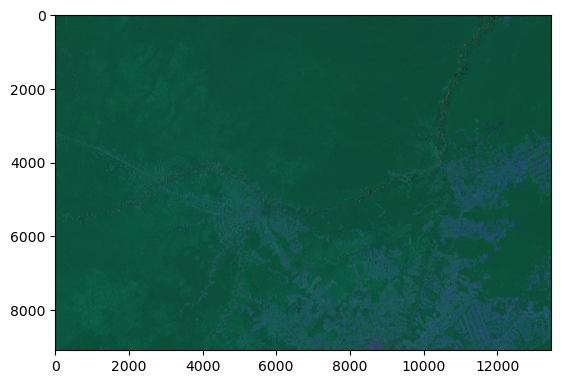

In [189]:
plt.imshow(landsat_acre[:,:,0:3])
plt.show()